In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=""

env: CUDA_VISIBLE_DEVICES=""


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import json, os, math
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torchinfo import summary
from data import prepare_data
from vit import ViTForClassfication
from train import Trainer
from utils import visualize_images, visualize_attention, load_experiment, get_param_count

In [39]:
epochs = 1 #@param {type: "integer"}
exp_name = f'vit-with-{epochs}-epochs' #@param {type:"string"}
batch_size = 64 #@param {type: "integer"}
lr = 1e-2  #@param {type: "number"}
save_model_every = 0 #@param {type: "integer"}


device = "cuda" if torch.cuda.is_available() else "cpu"

config = {
    "patch_size": 4,  # Input image size: 32x32 -> 8x8 patches
    "hidden_size": 48,
    "num_hidden_layers": 4,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 48, # 4 * hidden_size
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 10, # num_classes of CIFAR10
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": False,
}
# These are not hard constraints, but are used to prevent misconfigurations
assert config["hidden_size"] % config["num_attention_heads"] == 0
assert config['intermediate_size'] == 4 * config['hidden_size']
assert config['image_size'] % config['patch_size'] == 0

In [40]:
model = ViTForClassfication(config)
get_param_count(model)
119098

119098

In [41]:
# Load the CIFAR10 dataset
trainloader, testloader, _ = prepare_data(batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [42]:
for X, y in trainloader:
    break
X.shape

torch.Size([64, 3, 32, 32])

In [54]:
summary(model, input_data=X, device=device, depth=4)

Layer (type:depth-idx)                             Output Shape              Param #
ViTForClassfication                                [64, 10]                  --
├─Embeddings: 1-1                                  [64, 65, 48]              3,168
│    └─PatchEmbeddings: 2-1                        [64, 64, 48]              --
│    │    └─Sequential: 3-1                        [64, 64, 48]              --
│    │    │    └─Rearrange: 4-1                    [64, 64, 48]              --
│    │    │    └─Linear: 4-2                       [64, 64, 48]              2,352
│    └─Dropout: 2-2                                [64, 65, 48]              --
├─Encoder: 1-2                                     [64, 65, 48]              --
│    └─ModuleList: 2-3                             --                        --
│    │    └─Block: 3-2                             [64, 65, 48]              --
│    │    │    └─LayerNorm: 4-3                    [64, 65, 48]              96
│    │    │    └─MultiHeadAtt

In [58]:
path_size = 4
image_size = 32
in_channels = 3
embed_size = 48
N_patches = (image_size//path_size)**2
total_clases = 10
mlp_hidden_layer = 4 * embed_size

patch_embeddings = (path_size**2) * in_channels * embed_size + embed_size
position_embeddings = (N_patches + 1) * embed_size
cls_token = embed_size
last_layer = embed_size * total_clases + total_clases
mlp = mlp_hidden_layer * embed_size + embed_size + embed_size*mlp_hidden_layer + mlp_hidden_layer

num_attention_heads = 4
attention_head_size = embed_size // num_attention_heads

attention_blocks = num_attention_heads * (attention_head_size * embed_size + attention_head_size) * 3
mlp_mh_att = embed_size * embed_size + embed_size
ml_att = attention_blocks + mlp_mh_att

print(position_embeddings + cls_token)
print(patch_embeddings)
print(ml_att)
print(mlp)
print(last_layer)

3168
2352
9408
18672
490


In [10]:
# Create the model, optimizer, loss function and trainer

optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, loss_fn, exp_name, device=device)
trainer.train(trainloader, testloader, epochs, save_model_every_n_epochs=save_model_every)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1, Train loss: 1.8141, Test loss: 1.5518, Accuracy: 0.4347


Files already downloaded and verified


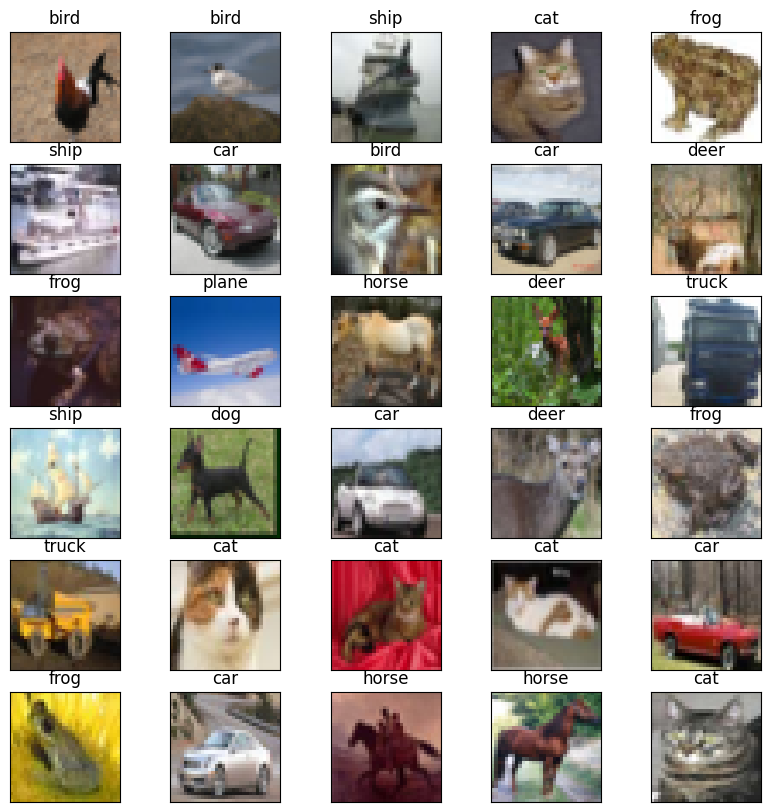

In [4]:
#@title Visualize Dataset
# Show some training images
visualize_images()

/tmp/ipykernel_63419/3635175294.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cpfile))


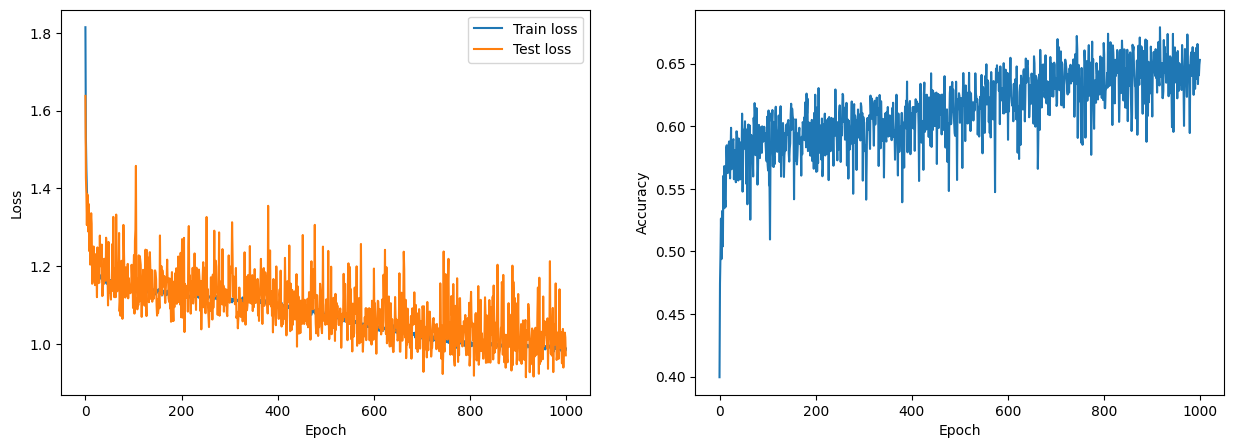

In [18]:
#@title Plot training Results
config, model, train_losses, test_losses, accuracies = load_experiment(f"{exp_name}/")

import matplotlib.pyplot as plt
# Create two subplots of train/test losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label="Train loss")
ax1.plot(test_losses, label="Test loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(accuracies)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
plt.savefig("metrics.png")
plt.show()

Files already downloaded and verified


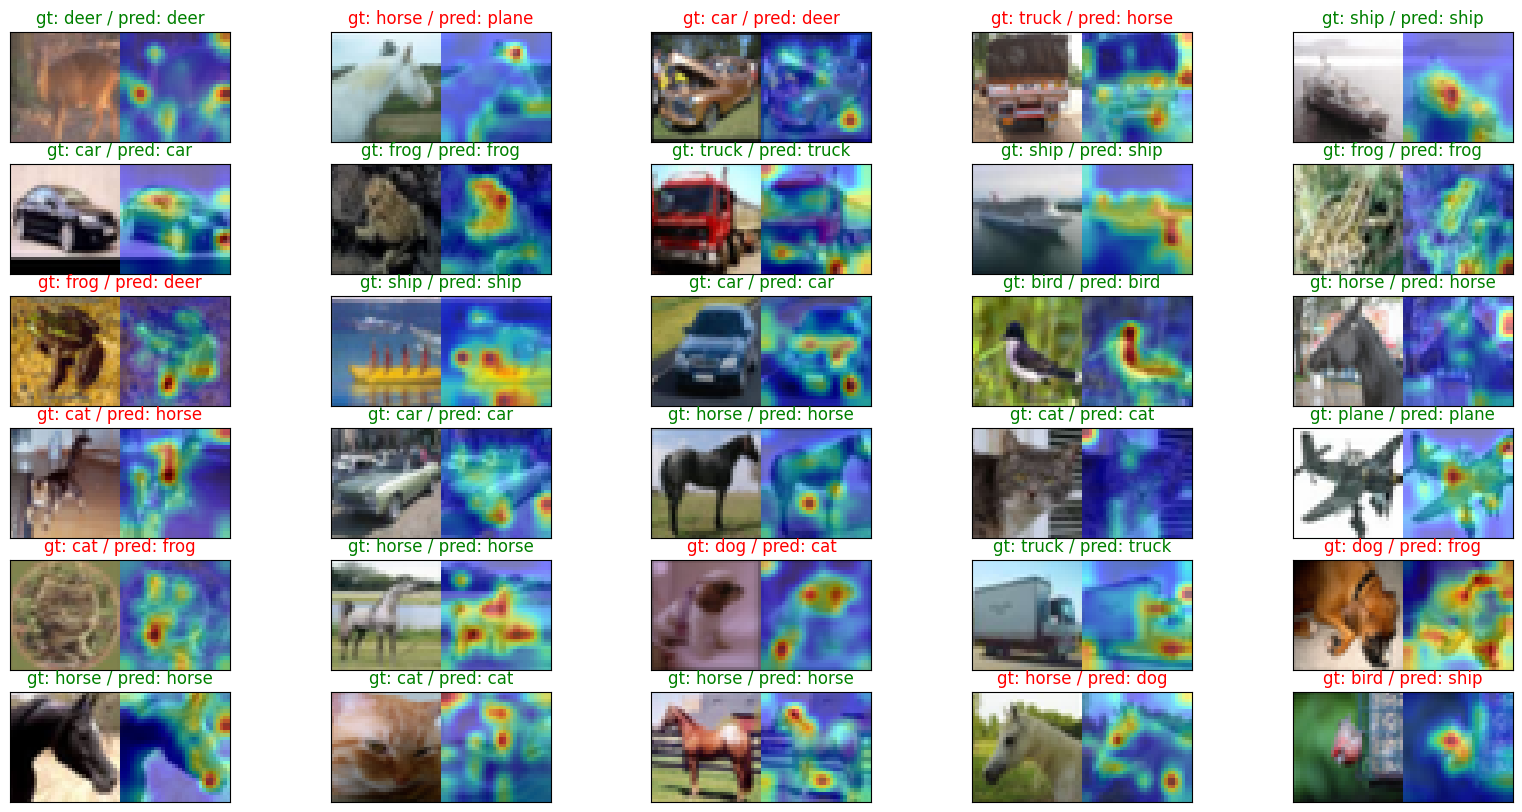

In [19]:
#@title Visualize Attetion
visualize_attention(model, "attention.png")